In [676]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

1. Reading the cascades ELG catalog

In [677]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.2/ELG/'
dataname = 'alltiles_ELGzinfo.fits'
catalog = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-3.1.fits')

#catalog = Table.read(diretory+dataname,hdu='ZBEST')
#zmag = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']

2. Selecting the deep coadds with EFFTIME_dark>3000

In [678]:
search_ELG = np.where((catalog['subset']=='deep')  & (catalog['EFFTIME_DARK']>3000))
catalog_ELG = catalog[search_ELG[0]].copy()

#search_ELG_oii = np.where((oii_catalog['subset']=='deep')  & (oii_catalog['EFFTIME_DARK']>3000))
#oii_catalog_ELG = oii_catalog[search_ELG_oii[0]].copy()
print('Number of deep coadds ELGs:',len(search_ELG[0]))
#print(len(set(catalog_ELG['TARGETID']*catalog_ELG['TILEID'])))
#print(len(oii_catalog_ELG))

Number of deep coadds ELGs: 70044


3. Selecting the short exposures coadds with EFFTIME_dark>700 (not deep or all)

In [679]:
search_ELG_short = np.where((catalog['subset']!='all') & (catalog['subset']!='deep') & (catalog['EFFTIME_DARK']>700))
catalog_ELG_short = catalog[search_ELG_short[0]].copy()
print('Number of short exposures:', len(catalog_ELG_short))

Number of short exposures: 480977


Just checking the EFFTIME_DARK distribution

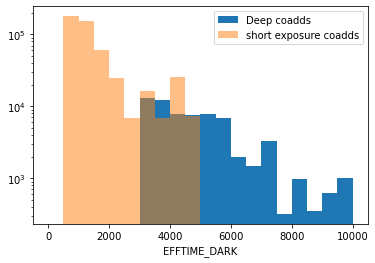

In [680]:
plt.hist(catalog_ELG['EFFTIME_DARK'],bins=20,range=(0,10000),label='Deep coadds')
plt.hist(catalog_ELG_short['EFFTIME_DARK'],bins=20,range=(0,10000),alpha=0.5,label='short exposure coadds')
plt.xlabel('EFFTIME_DARK')
plt.yscale('log')
plt.legend()

4. Creating pandas tables from fit formats

In [681]:
new_catalog_ELG_short = catalog_ELG_short[['TARGETID','Z','subset','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FOII','FOII_ERR']].to_pandas()
new_catalog_ELG = catalog_ELG['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_DARK','FIBERFLUX_R','FIBERFLUX_Z','EBV','ZWARN','FOII','FOII_ERR','SPECTYPE'].to_pandas()


5. Matching the two catalogs with targetid. The redrock information from the deep coadds has suffixes _deep and short coadds with _short

In [682]:
catalog_ELG_match = new_catalog_ELG.merge(new_catalog_ELG_short,on='TARGETID',how='left',suffixes=("_deep","_short"))

6. Removing same objects but observe in different tiles. and create redshift difference and zfibermag information

In [683]:
final_match_catalog = catalog_ELG_match[catalog_ELG_match['TILEID_deep']==catalog_ELG_match['TILEID_short']]
print(len(final_match_catalog))
final_match_catalog['dz']=abs(final_match_catalog['Z_deep']-final_match_catalog['Z_short'])/(1.+final_match_catalog['Z_deep'])
final_match_catalog['zfibermag']=-2.5*np.log10(final_match_catalog['FIBERFLUX_Z'])+22.5-1.211*final_match_catalog['EBV']
final_match_catalog['rfibermag']=-2.5*np.log10(final_match_catalog['FIBERFLUX_R'])+22.5-2.165*final_match_catalog['EBV']
final_match_catalog['OII_SN_deep']=final_match_catalog['FOII_deep']/final_match_catalog['FOII_ERR_deep']
final_match_catalog['OII_SN_short']=final_match_catalog['FOII_short']/final_match_catalog['FOII_ERR_short']

451345


# 7. Selecting targets with [OII] from Anand with non repeatable redshifts.


Selection:

    a. |z_deep-z_short|/(1+z_deep)>0.0033
    
    b. 0.6<z_deep<1.58
    
    c. FOII_deep>0
    
    d. FOII_short>0
    
    e. ELG_deep satisfies Anand's selection
    
    f. ELG_short satisfies Anand's selection
    
    g. ZWARN_short<=4 & ZWARN_deep<=4
    


In [684]:
dz_not_good_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & 
                                          (final_match_catalog['Z_deep']>=0.6) & 
                                          (final_match_catalog['Z_deep']<=1.58) &
                                          (final_match_catalog['FOII_deep']>0) & 
                                          (final_match_catalog['FOII_short']>0) & 
                                          (np.log10(final_match_catalog['OII_SN_deep'])>(0.9-0.2*np.log10(final_match_catalog['DELTACHI2_deep']))) &                                           
                                          (np.log10(final_match_catalog['OII_SN_short'])>(0.9-0.2*np.log10(final_match_catalog['DELTACHI2_short']))) &                                           
                                          (final_match_catalog['ZWARN_deep']<=4) &
                                          (final_match_catalog['ZWARN_short']<=4)]


dz_not_good_catalog['VI_selection']=0

8. Looking at the DELTACHI2_deep distribution with non-repeatable redshifts. What is interesting is that  there are many objects with high Deltachi2 but non-repeatable redshifts.

(1.0, 5.0)

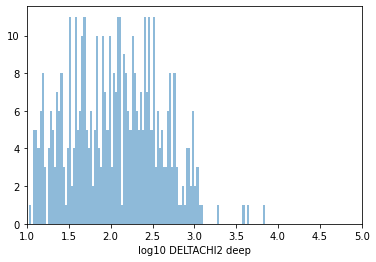

In [685]:
plt.hist(np.log10(dz_not_good_catalog['DELTACHI2_deep']),bins=200,range=(0,5),alpha=0.5)
plt.xlabel('log10 DELTACHI2 deep')
plt.xlim(1,5)
#plt.axvline(2.55)
#plt.axvline(2.525)

In [686]:
print('Number of unique targets in the selection:',len(set(dz_not_good_catalog['TARGETID']*dz_not_good_catalog['TILEID_deep'])))
total_unique_sources = len(set(dz_not_good_catalog['TARGETID']*dz_not_good_catalog['TILEID_deep']))

Number of unique targets in the selection: 351


# 9. low redshift selection 

a. |Z_deep-Z_short|/(1+Z_deep)>0.0033

b. Z_deep<0.6

c. DELTACHI2_short>10

d. DELTATCHI2_deep>50

f ZWARN_deep and ZWARN_short<=4

In [687]:
low_z_object = final_match_catalog[(final_match_catalog['Z_deep']<0.6) & 
                                   (final_match_catalog['dz']>0.0033) & 
                                   (final_match_catalog['DELTACHI2_short']>20) & 
                                   (final_match_catalog['DELTACHI2_deep']>40) & 
                                   (final_match_catalog['ZWARN_deep']<=4) &
                                   (final_match_catalog['ZWARN_short']<=4) 
                                  # (final_match_catalog['SPECTYPE']==b'GALAXY')
                                  ]
low_z_object['VI_selection']=1
print(len(set(low_z_object['TARGETID']*low_z_object['TILEID_deep'])))
total_unique_sources+=len(set(low_z_object['TARGETID']*low_z_object['TILEID_deep']))

485


In [701]:
'''
high_z_object = final_match_catalog[(final_match_catalog['dz']>0.0033) & 
                                    (final_match_catalog['DELTACHI2_deep']<100) & 
                                    (final_match_catalog['DELTACHI2_deep']>20) & 
                                    (final_match_catalog['Z_deep']>1.501) & 
                                    (final_match_catalog['Z_deep']<1.635)]
high_z_object['VI_selection']=2
print(len(set(high_z_object['TARGETID']*high_z_object['TILEID_deep'])))
total_unique_sources+=len(set(high_z_object['TARGETID']*high_z_object['TILEID_deep']))
'''

"\nhigh_z_object = final_match_catalog[(final_match_catalog['dz']>0.0033) & \n                                    (final_match_catalog['DELTACHI2_deep']<100) & \n                                    (final_match_catalog['DELTACHI2_deep']>20) & \n                                    (final_match_catalog['Z_deep']>1.501) & \n                                    (final_match_catalog['Z_deep']<1.635)]\nhigh_z_object['VI_selection']=2\nprint(len(set(high_z_object['TARGETID']*high_z_object['TILEID_deep'])))\ntotal_unique_sources+=len(set(high_z_object['TARGETID']*high_z_object['TILEID_deep']))\n"

Using Ashley's catalog and extracting the first 3 best redrock fits

In [689]:
catalog_Ashley = Table.read('/global/cscratch1/sd/ajross/SV1/redshift_comps/cascades/test/ELG/alltiles_ELGzinfo_wh5.fits')
search_ELG_high_z = np.where((catalog_Ashley['subset']=='deep')  & (catalog_Ashley['EFFTIME_DARK']>3000) & 
                             (catalog_Ashley['Z']>1.497) & (catalog_Ashley['Z']<1.635))
catalog_Ashley_high_z = catalog_Ashley[search_ELG_high_z[0]].copy()

search_ELG_Ashley_short = np.where((catalog_Ashley['subset']!='all') & (catalog_Ashley['subset']!='deep') & (catalog_Ashley['EFFTIME_DARK']>700))
catalog_Ashley_short = catalog_Ashley[search_ELG_Ashley_short[0]].copy()

new_catalog_ELG_Ashley_short = catalog_Ashley_short[['TARGETID','Z','subset','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','zwarn_1','zwarn_2','zwarn_3','z_1','z_2','z_3','deltachi2_1','deltachi2_2','deltachi2_3']].to_pandas()
new_catalog_ELG_Ashley_highz = catalog_Ashley_high_z[['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_DARK','FIBERFLUX_R','FIBERFLUX_Z','EBV','ZWARN','zwarn_1','zwarn_2','zwarn_3','z_1','z_2','z_3','deltachi2_1','deltachi2_2','deltachi2_3']].to_pandas()
catalog_ELG_match_high_z = new_catalog_ELG_Ashley_highz.merge(new_catalog_ELG_Ashley_short,on='TARGETID',how='left',suffixes=("_deep","_short"))

final_match_catalog_high_z = catalog_ELG_match_high_z[catalog_ELG_match_high_z['TILEID_deep']==catalog_ELG_match_high_z['TILEID_short']]

# 10. High z selection 1

a. dz>0.0033

b. 1.497<Z_deep<1.635

c. DELTACHI2_deep>40

d. DELTACHI2_short>20

e. ZWARN_deep & ZWARN_short<=4

In [690]:
final_match_catalog_high_z['combine_deltachi2_deep']=final_match_catalog_high_z['DELTACHI2_deep']+final_match_catalog_high_z['deltachi2_1_deep']+final_match_catalog_high_z['deltachi2_2_deep']
final_match_catalog_high_z['combine_deltachi2_short']=final_match_catalog_high_z['DELTACHI2_short']+final_match_catalog_high_z['deltachi2_1_short']+final_match_catalog_high_z['deltachi2_2_short']
final_match_catalog_high_z['dz']=abs(final_match_catalog_high_z['Z_deep']-final_match_catalog_high_z['Z_short'])/(1+final_match_catalog_high_z['Z_deep'])

high_z_object_simple_cut = final_match_catalog_high_z[(final_match_catalog_high_z['dz']>0.0033) & 
                                    (final_match_catalog_high_z['DELTACHI2_deep']>40) &
                                    (final_match_catalog_high_z['DELTACHI2_short']>20) &
                                    (final_match_catalog_high_z['ZWARN_deep']<=4) & 
                                    (final_match_catalog_high_z['ZWARN_short']<=4)]
high_z_object_simple_cut['VI_selection']=2                                  
print(len(set(high_z_object_simple_cut['TARGETID']*high_z_object_simple_cut['TILEID_deep'])))
total_unique_sources+=len(set(high_z_object_simple_cut['TARGETID']*high_z_object_simple_cut['TILEID_deep']))

233


# 10. High z selection 2

a. dz>0.0033

b. 1.497<Z_deep<1.635

c. Z_1 as [OIII] or Ha line

d. DELTACHI2_combine_deep<100

In [691]:
redshift_selection = (((final_match_catalog_high_z['z_1_deep']>=3710.*(1+final_match_catalog_high_z['Z_deep'])/5007.-1) &
                    (final_match_catalog_high_z['z_1_deep']<3770.*(1+final_match_catalog_high_z['Z_deep'])/5007.-1)) | 
                    ((final_match_catalog_high_z['z_1_deep']>=3720.*(1+final_match_catalog_high_z['Z_deep'])/6563.-1) &
                    (final_match_catalog_high_z['z_1_deep']<3740.*(1+final_match_catalog_high_z['Z_deep'])/6563.-1)))

deep_good_highz_catalog = final_match_catalog_high_z[redshift_selection]

high_z_sample_Ha_OIII = deep_good_highz_catalog[(deep_good_highz_catalog['combine_deltachi2_deep']<100)]
print(len(set(high_z_sample_Ha_OIII['TARGETID']*high_z_sample_Ha_OIII['TILEID_deep'])))
total_unique_sources+=len(set(high_z_sample_Ha_OIII['TARGETID']*high_z_sample_Ha_OIII['TILEID_deep']))

high_z_sample_Ha_OIII['VI_selection']=3
#redshift_selection_short = (((deep_good_highz_catalog['z_1_short']>=3710.*(1+deep_good_highz_catalog['Z_short'])/5007-1) &
#                    (deep_good_highz_catalog['z_1_short']<3770.*(1+deep_good_highz_catalog['Z_short'])/5007.-1)) | 
#                    ((deep_good_highz_catalog['z_1_short']>=3720.*(1+deep_good_highz_catalog['Z_short'])/6563.-1) &
#                    (deep_good_highz_catalog['z_1_short']<3740.*(1+deep_good_highz_catalog['Z_short'])/6563.-1)))


#deep_good_short_good_highz_catalog = deep_good_highz_catalog#[redshift_selection_short]
#final_high_z_sample = deep_good_short_good_highz_catalog[
#                                             #(deep_good_short_good_highz_catalog['dz']>0.0033) &
#                                             (deep_good_short_good_highz_catalog['combine_deltachi2_deep']<100) & 
#                                             (deep_good_short_good_highz_catalog['ZWARN_deep']<=4) & 
#                                             (deep_good_short_good_highz_catalog['ZWARN_short']<=4)]

#plt.hist(np.log10(deep_good_short_good_highz_catalog['combine_deltachi2_deep']),bins=20,range=(0,5))
#plt.hist(np.log10(deep_good_highz_catalog['combine_deltachi2_deep']),bins=20,range=(0,5),alpha=0.5)

#print(len(set(final_high_z_sample['TARGETID'])))
#print(len(set(deep_good_highz_catalog['TARGETID'])))

#final_match_catalog_high_z['DELTACHI2']
#len(deep_good_highz_catalog[redshift_selection_short])
#((z_1>=3710.*(1+best_z)/5007-1) & (z_1<3770.*(1+best_z)/5007-1)) | ((z_1>=3720.*(1+best_z)/6563-1) & (z_1<3740.*(1+best_z)/6563-1)))
#final_match_catalog_high_z[]

#plt.scatter(final_match_catalog_high_z['Z_deep'][redshift_selection],final_match_catalog_high_z['z_1_deep'][redshift_selection])

392


# 11. High redshift sources

a. |z_deep-z_short|/(1+z_deep)>0.0033

b. z_deep>1.635

c. DELTACHI2_short>20

d. DELTACHI2_deep>40

f ZWARN_deep<=4 & ZWARN_short<=4


In [692]:
extreme_high_z_object = final_match_catalog[(final_match_catalog['Z_deep']>1.635) & 
                                   (final_match_catalog['dz']>0.0033) & 
                                   (final_match_catalog['DELTACHI2_short']>20) & 
                                   (final_match_catalog['DELTACHI2_deep']>40) & 
                                   #(final_match_catalog['DELTACHI2_deep']<100) & 
                                   (final_match_catalog['ZWARN_deep']<=4) &
                                   (final_match_catalog['ZWARN_short']<=4)
                                  ]
extreme_high_z_object['VI_selection']=4
print(len(set(extreme_high_z_object['TARGETID']*extreme_high_z_object['TILEID_deep'])))
total_unique_sources+=len(set(extreme_high_z_object['TARGETID']*extreme_high_z_object['TILEID_deep']))

372


In [693]:
combined_catalog  = dz_not_good_catalog
combined_catalog = combined_catalog.append(extreme_high_z_object,ignore_index=True)
combined_catalog = combined_catalog.append(low_z_object,ignore_index=True)
combined_catalog = combined_catalog.append(high_z_object_simple_cut,ignore_index=True)
combined_catalog = combined_catalog.append(high_z_sample_Ha_OIII,ignore_index=True)

In [697]:
print(total_unique_sources)
print(len(set(combined_catalog['TARGETID']*combined_catalog['TILEID_deep'])))

1833
1802


10. Combining the two catalogs and producing a list with 
TILEID, TARGETID, ID_FOR_selection

In [708]:
all_tileid = combined_catalog['TILEID_deep']
all_targetid = combined_catalog['TARGETID']
all_VI_selection = combined_catalog['VI_selection']
#all_tileid = np.append(dz_not_good_catalog['TILEID_deep'].to_numpy(),high_z_strange_object['TILEID'].to_numpy())
#all_targetid = np.append(dz_not_good_catalog['TARGETID'].to_numpy(),high_z_strange_object['TARGETID'].to_numpy())
#all_VI_selection = np.append(np.arange(0,len(dz_not_good_catalog['TARGETID'].to_numpy()))*0.,
#                             np.arange(0,len(high_z_strange_object['TARGETID'].to_numpy()))*0.+1)

11. Creating an unique target list with no repetition 

In [715]:
TILEID = []
FINAL_TARGETID = []
FINAL_selection = []
unique_tileid = np.array(list(set(all_tileid)))
Number_of_object_per_tile = {}
for i_tile in range(0,len(unique_tileid)):
    if (unique_tileid[i_tile]!=80606) & (unique_tileid[i_tile]!=80608) & (unique_tileid[i_tile]!=80610):
        search = np.where(all_tileid==unique_tileid[i_tile])
        tmp_targetid = all_targetid[search[0]]

        unique_targetid = np.array(list(set(tmp_targetid)))
        Number_of_object_per_tile[unique_tileid[i_tile]]=len(unique_targetid)
        for i_td in range(0,len(unique_targetid)):
            TILEID.append(unique_tileid[i_tile])
            FINAL_TARGETID.append(unique_targetid[i_td])
            search_selection = np.where((all_tileid==unique_tileid[i_tile]) & (all_targetid==unique_targetid[i_td]))
            FINAL_selection.append(int(all_VI_selection[search_selection[0][0]]))

In [716]:
print(len(FINAL_selection))
Number_of_object_per_tile

1417


{80669: 49,
 80673: 82,
 80675: 57,
 80676: 26,
 80677: 43,
 80678: 24,
 80679: 32,
 80680: 24,
 80681: 83,
 80682: 30,
 80683: 35,
 80684: 12,
 80685: 48,
 80686: 15,
 80688: 23,
 80689: 41,
 80690: 25,
 80692: 25,
 80693: 64,
 80694: 24,
 80699: 41,
 80700: 19,
 80701: 81,
 80705: 79,
 80707: 63,
 80709: 36,
 80711: 41,
 80712: 19,
 80605: 66,
 80607: 39,
 80609: 39,
 80620: 23,
 80621: 50,
 80622: 17,
 80623: 42}

In [49]:
d = {'TILEID':TILEID,'TARGETID':FINAL_TARGETID,'VI_selection':FINAL_selection}
df = pd.DataFrame(data=d)

In [178]:
df.to_csv('SV_cascades_ELG_VI_target_list.v1.csv',index=False)

In [179]:
new_data = pd.read_csv('SV_cascades_ELG_VI_target_list.v1.csv')

In [180]:
print('TOTAL selected spectra for VI:',len(TILEID))

TOTAL selected spectra for VI: 2318
